# Exploratory Data Analysis

## Introduction and Context

## Initial Settings

### Roots and Paths

In [1]:
import sys
from pathlib import Path

# path to project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

### Libraries and Dependencies

In [2]:
import src.utils as ut
import src.config as cf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from IPython.display import display
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier


pd.options.display.max_columns = None
sns.set_style('dark')
sns.set_palette('dark')

project path: C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\250419 Credit Card Approval
raw data path: C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\250419 Credit Card Approval\data\raw_data.csv
model path C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\250419 Credit Card Approval\models\model.pkl
results path C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\250419 Credit Card Approval\results


### Data Loading

In [3]:
df = ut.load_data(cf.paths['data_raw'])
labels = ut.load_data(cf.paths['labels'])

In [4]:
df.head()

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2


In [5]:
labels.head()

,Ind_ID,label
0,5008827,1
1,5009744,1
2,5009746,1
3,5009749,1
4,5009752,1


In [6]:
df = pd.merge(df, labels, how = 'left')

In [7]:
target = 'label'
df.head()

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,label
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2,1
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2,1
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1


In [8]:
df = df.rename(columns = {'label': 'target_encoded'})

## Preliminary EDA

### Basic Information

In [9]:
# dataset size
print(f'Dimensions: {df.shape}')

# summary table
ut.summary_info(df)

Dimensions: (1548, 19)


Column,Non-Null Count,Missing %,Unique Values,Data Type
Type_Occupation,"1,060",31.520000,18,object
Annual_income,"1,525",1.490000,115,float64
Birthday_count,"1,526",1.420000,"1,270",float64
GENDER,"1,541",0.450000,2,object
Ind_ID,"1,548",0.000000,"1,548",int64
Employed_days,"1,548",0.000000,956,int64
Family_Members,"1,548",0.000000,7,int64
EMAIL_ID,"1,548",0.000000,2,int64
Phone,"1,548",0.000000,2,int64
Work_Phone,"1,548",0.000000,2,int64


### Missing Values

In [10]:
ut.missing_values_by_pivot(df, return_type = 'percentage',percentage_base = 'total') 

,Missing %
Ind_ID,0.000000
GENDER,0.452196
Car_Owner,0.000000
Propert_Owner,0.000000
CHILDREN,0.000000
Annual_income,1.485788
Type_Income,0.000000
EDUCATION,0.000000
Marital_status,0.000000
Housing_type,0.000000


### Preliminary Preprocessing

Drop IDs because they hold no predictive power (they are all unique and no patterns can be exploided)

In [11]:
# drop ID column
df = df.drop('Ind_ID', axis = 1)

## Feature - Target Relevance Analysis

### Numerical Features Relevance

#### Feature - Target Correlations

In [12]:
# peak at unique target values
print(df['target_encoded'].unique())

[1 0]


Explore correlations for the numerical features vs target feature. The higher the absolute correlation, the better. This will give us an idea of the predictive power of the numerical variables

In [13]:
# target - numeric correlations
correlations = df.select_dtypes(include = ['float64', 'int64']).corrwith(df['target_encoded'])
correlations = correlations.sort_values(ascending = False)

# show
print('Target Correlations:')
correlations_table = pd.DataFrame(correlations, columns = ['Correlation'])
correlations_table

Target Correlations:


,Correlation
target_encoded,1.000000
Employed_days,0.031408
Annual_income,0.027456
EMAIL_ID,0.012921
Phone,-0.000664
Work_Phone,-0.007046
CHILDREN,-0.021646
Family_Members,-0.030709
Birthday_count,-0.045097
Mobile_phone,NaN


#### Feature - Target Correlation Visualization

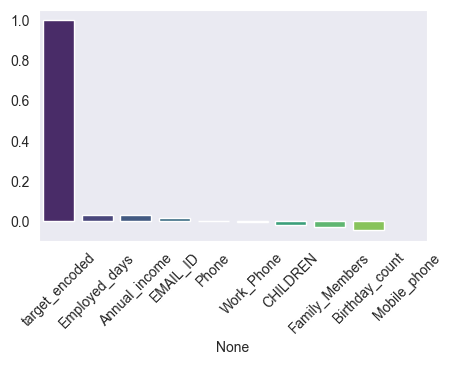

In [14]:
plt.figure(figsize = (5, 3))
sns.barplot(
    x = correlations.index, 
    y = correlations.values, 
    palette = 'viridis',
    hue = correlations.index,
    dodge = False)
plt.xticks(rotation = 45)
plt.show()

#### ANOVA Revelance Analysis

Numerical Features with p-value below 0.05 are more significant. This is modeled through a F-Statistic that measures the difference between groups in the target variable, relative to the inner dispersion

In [15]:
numerical_cols = df.select_dtypes(include = ['int64', 'float64']).drop(columns = 'target_encoded', errors = 'ignore').columns

anova_results = []

for col in numerical_cols:
    # create groups based on target categories
    groups = [df[df['target_encoded'] == category][col] for category in df['target_encoded'].unique()]
    
    # calculate F-statistic and p-value
    f_stat, p_value = f_oneway(*groups)
    
    # save results in a dictionary
    anova_results.append({'Feature': col, 'F-Statistic': f_stat, 'P-Value': p_value})

# convert results to DataFrame
anova_table = pd.DataFrame(anova_results)

# formatting
anova_table = anova_table.sort_values(by = 'P-Value', ascending = False)

anova_table.style.format({
    'F-Statistic': '{:.2f}',
    'P-Value': '{:.3f}'
})

anova_table
    

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


,Feature,F-Statistic,P-Value
6,Phone,0.000682,0.979166
5,Work_Phone,0.076753,0.781784
7,EMAIL_ID,0.258162,0.611458
0,CHILDREN,0.724721,0.394731
8,Family_Members,1.459357,0.227217
3,Employed_days,1.526605,0.216810
1,Annual_income,NaN,NaN
2,Birthday_count,NaN,NaN
4,Mobile_phone,NaN,NaN


### Categorical Features Relevance

#### Categorical Features Selection

In [16]:
cat_columns = list(set(df.columns) - set(numerical_cols))

cat_columns.remove('target_encoded')

#### Chi - Squared Test

This test is to evaluate independence between two categorical features. We apply it to see if the categorical predictive features are independent to the categorical target feature. If the p-value is less than 0.05 it means that the features are NOT independent and the feature hold predictive power; it should be kept in the model

In [17]:
chi2_results = []

for col in cat_columns:
    # contigency table
    contingency_table = pd.crosstab(df[col], df['target_encoded'])
    
    # chi-squared
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    
    # append results
    chi2_results.append({'Feature': col, 'Chi2': chi2, 'P-Value': p})
    
# formatting
chi2_df = pd.DataFrame(chi2_results).sort_values(by = 'Chi2', ascending = False)

chi2_df.style.format({
    'Chi2': '{:.2f}',
    'P-Value': '{:.3f}'
})

chi2_df

,Feature,Chi2,P-Value
5,Type_Occupation,37.225476,0.003136
3,Housing_type,28.042795,0.000036
4,Type_Income,13.598556,0.003506
1,Marital_status,10.524108,0.032467
2,EDUCATION,9.205670,0.056159
6,GENDER,3.982163,0.045984
7,Propert_Owner,0.384679,0.535110
0,Car_Owner,0.247884,0.618569


### Feature Ranking

##### Preliminary Preprocessing

Small preliminary processing section. This is NOT the final preprocessing pipeline. It is used to prep the set to be used in a Random Forest model and evaluate feature relevance according to this model

In [18]:
df_encoded = df.copy()

for col in cat_columns:
    encoder = LabelEncoder()
    df_encoded[col] = encoder.fit_transform(df_encoded[col])

df_encoded.head()

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,target_encoded
0,1,1,1,0,180000.0,1,1,1,1,-18772.0,365243,1,0,0,0,18,2,1
1,0,1,0,0,315000.0,0,1,1,1,-13557.0,-586,1,1,1,0,18,2,1
2,0,1,0,0,315000.0,0,1,1,1,NaN,-586,1,1,1,0,18,2,1
3,0,1,0,0,NaN,0,1,1,1,-13557.0,-586,1,1,1,0,18,2,1
4,0,1,0,0,315000.0,0,1,1,1,-13557.0,-586,1,1,1,0,18,2,1


##### Target - Feature Split

In [19]:
X = df_encoded.drop(['target_encoded'], axis = 1)
y = df_encoded['target_encoded']

##### Simple Random Forest Fit

In [20]:
model = RandomForestClassifier(random_state = 123, n_estimators = 100)
model.fit(X, y)

feature_importance = pd.Series(model.feature_importances_, index = X.columns).sort_values(ascending = False)

##### Ranking Table

In [21]:
importance_df = pd.DataFrame({
    'Feature': feature_importance.index,
    'Importance': feature_importance.values
}).sort_values(by = 'Importance', ascending = False)

importance_df

,Feature,Importance
0,Birthday_count,0.217809
1,Employed_days,0.176020
2,Annual_income,0.164582
3,Type_Occupation,0.073978
4,GENDER,0.042452
5,Family_Members,0.042010
6,Marital_status,0.041266
7,EDUCATION,0.034692
8,Type_Income,0.033787
9,Housing_type,0.031936


##### Ranking Visualization

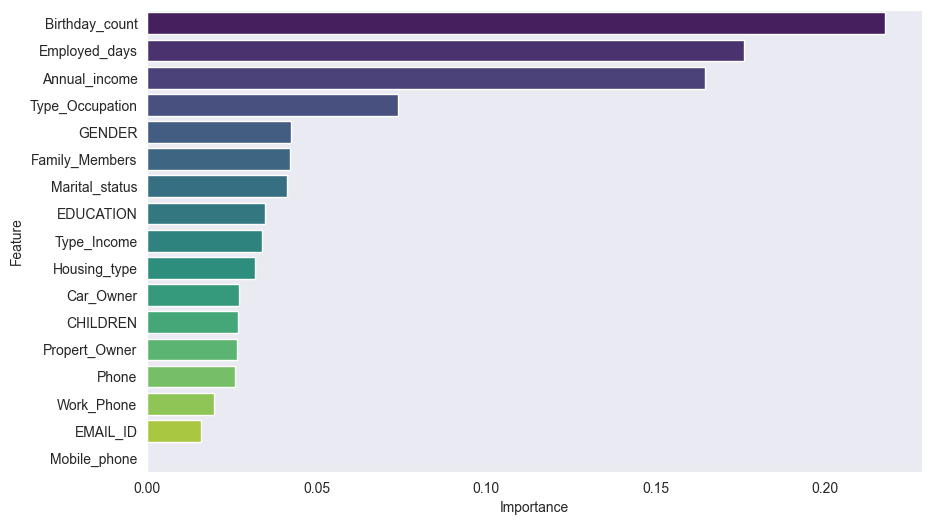

In [22]:
plt.figure(figsize = (10, 6))

sns.barplot(
    x = 'Importance', 
    y = 'Feature', 
    data = importance_df, 
    palette = 'viridis',
    hue = 'Feature',
    dodge = False)
plt.show()

### Relevant Feature Selection

From the previous analyses, we can form an educated opinion on relevant features and explore those
This approach is useful for limited-feature visualizations and streamlined dimensionality

In [23]:
relevant_num_cols = [
    'Birthday_count',
    'Family_Members',
    'Annual_income'
]

relevant_cat_cols = [
    'Type_Occupation',
    'GENDER',
    'EDUCATION'
]

## Numerical Feature Analysis

### Statistical Summary

In [24]:
# statistical summary
df.describe().applymap(lambda x: ut.format_cell(x)).style.applymap(ut.center_align)

,CHILDREN,Annual_income,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Family_Members,target_encoded
count,"1,548","1,525","1,526","1,548","1,548","1,548","1,548","1,548","1,548","1,548"
mean,0.41,"191,399.33","-16,040.34","59,364.69",1,0.21,0.31,0.09,2.16,0.11
std,0.78,"113,253.00","4,229.50","137,808.06",0,0.41,0.46,0.29,0.95,0.32
min,0,"33,750","-24,946","-14,887",1,0,0,0,1,0
25%,0,"121,500","-19,553","-3,174.50",1,0,0,0,2,0
50%,0,"166,500","-15,661.50","-1,565",1,0,0,0,2,0
75%,1,"225,000","-12,417",-431.75,1,0,1,0,3,0
max,14,"1,575,000","-7,705","365,243",1,1,1,1,15,1


### Histograms

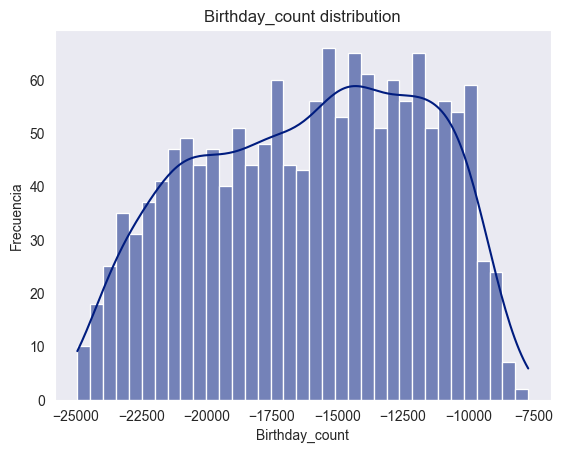

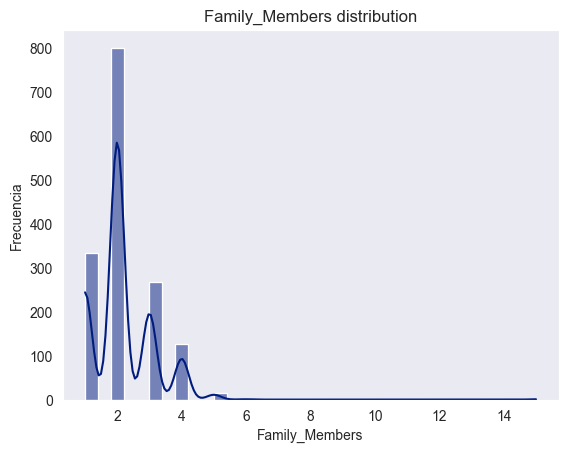

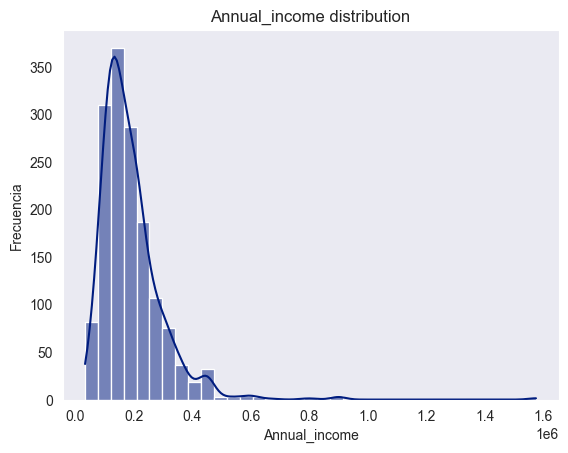

In [25]:
# create histogram and density curves

for col in relevant_num_cols:
    sns.histplot(df[col], kde = True, bins = 35)
    plt.title(f'{col} distribution')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

### Box Plots

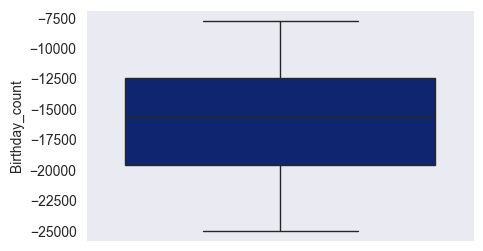

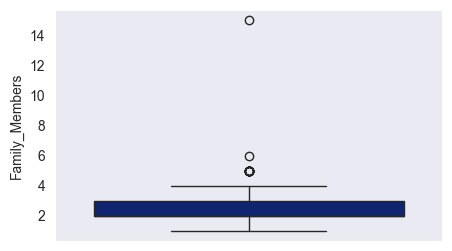

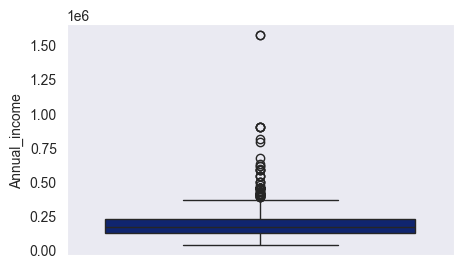

In [26]:
for col in relevant_num_cols:
    plt.figure(figsize = (5, 3))
    sns.boxplot(y = df[col])
    plt.ylabel(col)
    plt.show()

### Pair Plots

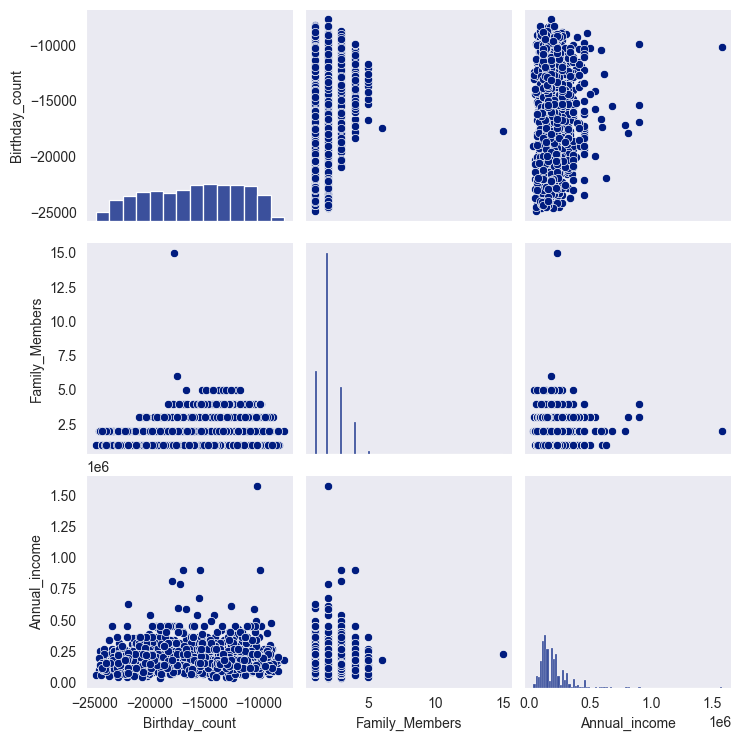

In [27]:
sns.pairplot(df[relevant_num_cols])
plt.show()

### Heatmap

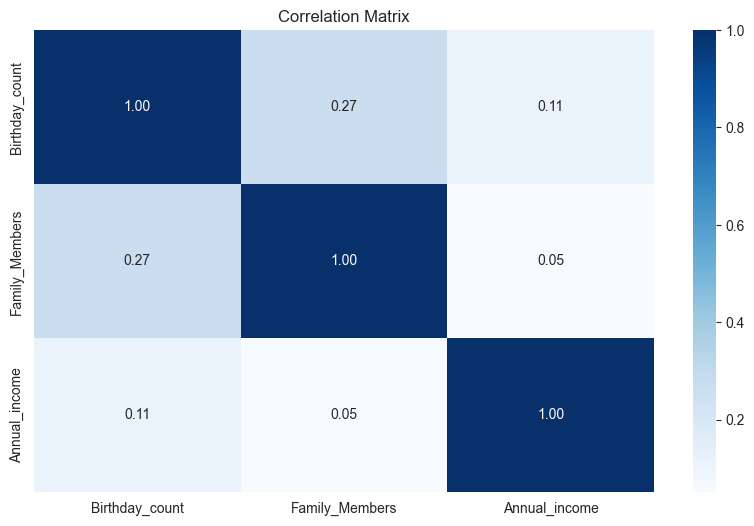

In [28]:
correlation_matrix = df[relevant_num_cols].corr()
plt.figure(figsize = (10, 6))
sns.heatmap(correlation_matrix, annot = True, fmt = ".2f", cmap = 'Blues', cbar = True)
plt.title('Correlation Matrix')
plt.show()

## Categorical Feature Analysis

### Uniqueness

In [29]:
ut.uniqueness_categorical_columns(df, max_categories = 10)

--- Column: GENDER ---
Unique values: 2


Category,Percentage
F,63.14%
M,36.86%




--- Column: Car_Owner ---
Unique values: 2


Category,Percentage
N,59.69%
Y,40.31%




--- Column: Propert_Owner ---
Unique values: 2


Category,Percentage
Y,65.25%
N,34.75%




--- Column: Type_Income ---
Unique values: 4


Category,Percentage
Working,51.55%
Commercial associate,23.58%
Pensioner,17.38%
State servant,7.49%




--- Column: EDUCATION ---
Unique values: 5


Category,Percentage
Secondary / secondary special,66.60%
Higher education,27.52%
Incomplete higher,4.39%
Lower secondary,1.36%
Academic degree,0.13%




--- Column: Marital_status ---
Unique values: 5


Category,Percentage
Married,67.76%
Single / not married,14.66%
Civil marriage,6.52%
Separated,6.20%
Widow,4.84%




--- Column: Housing_type ---
Unique values: 6


Category,Percentage
House / apartment,89.15%
With parents,5.17%
Municipal apartment,3.42%
Rented apartment,1.36%
Office apartment,0.58%
Co-op apartment,0.32%




--- Column: Type_Occupation ---
Unique values: 18


Category,Percentage
Laborers,25.28%
Core staff,16.42%
Managers,12.83%
Sales staff,11.51%
Drivers,8.11%
High skill tech staff,6.13%
Medicine staff,4.72%
Accountants,4.15%
Security staff,2.36%
Cleaning staff,2.08%


... showing the top 10 most common values




### Count Plot

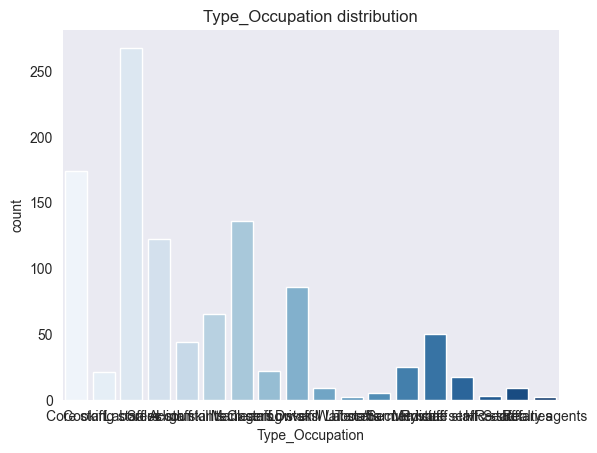

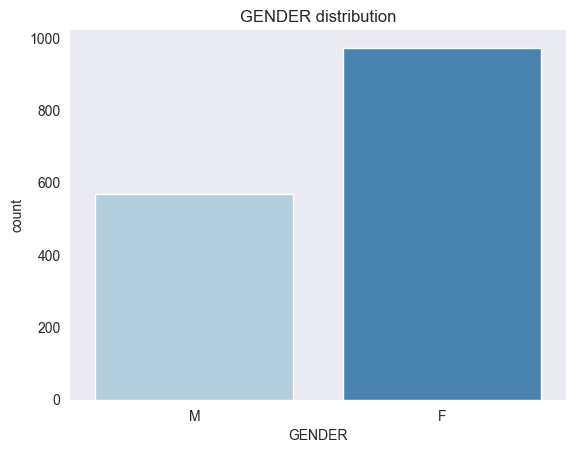

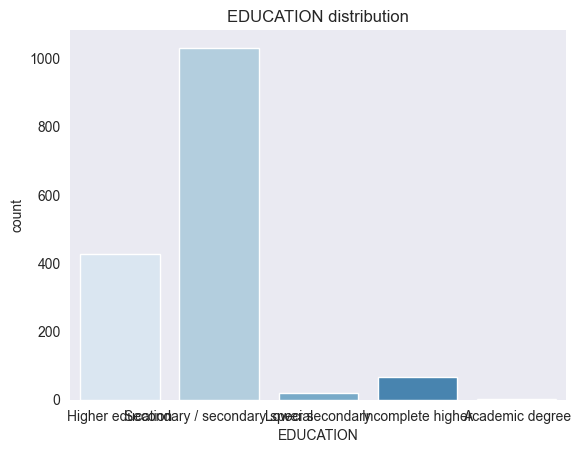

In [30]:
for col in relevant_cat_cols:
    sns.countplot(x = col, data = df, palette = 'Blues', hue = col, legend= False)
    plt.title(f'{col} distribution')
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    
    plt.show()

### Crosstabs

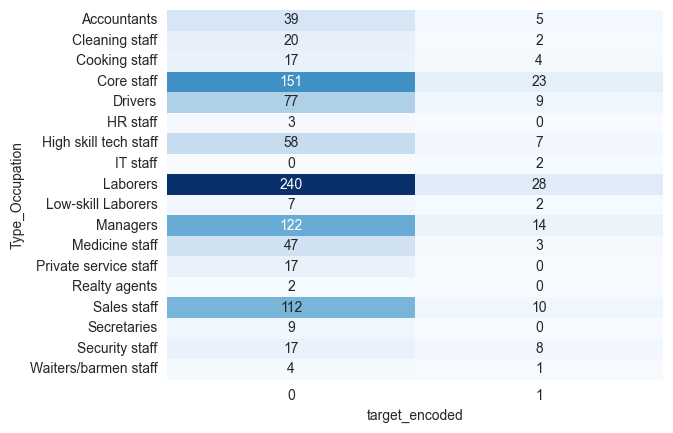

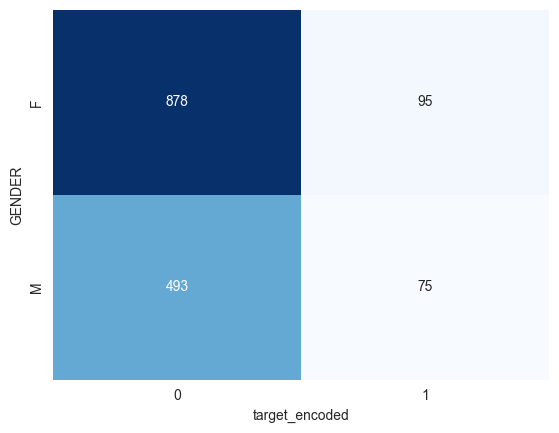

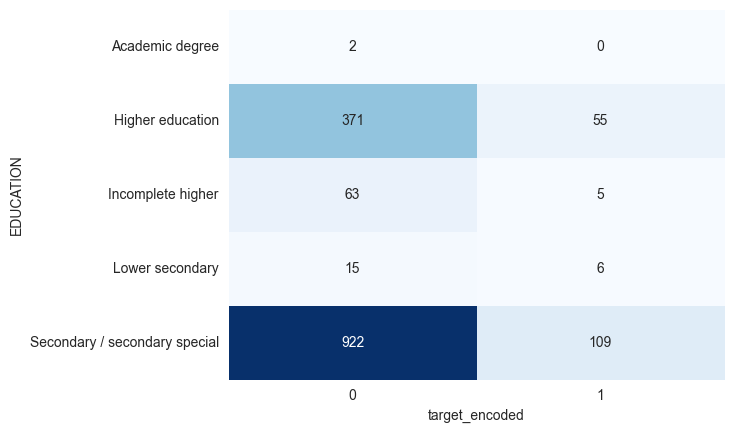

In [31]:
for col in relevant_cat_cols:
    cross = pd.crosstab(df[col], df['target_encoded'])

    sns.heatmap(cross, annot = True, fmt = 'd', cmap = 'Blues', cbar= False)
    plt.show()

<Axes: xlabel='target_encoded', ylabel='GENDER-Type_Occupation'>

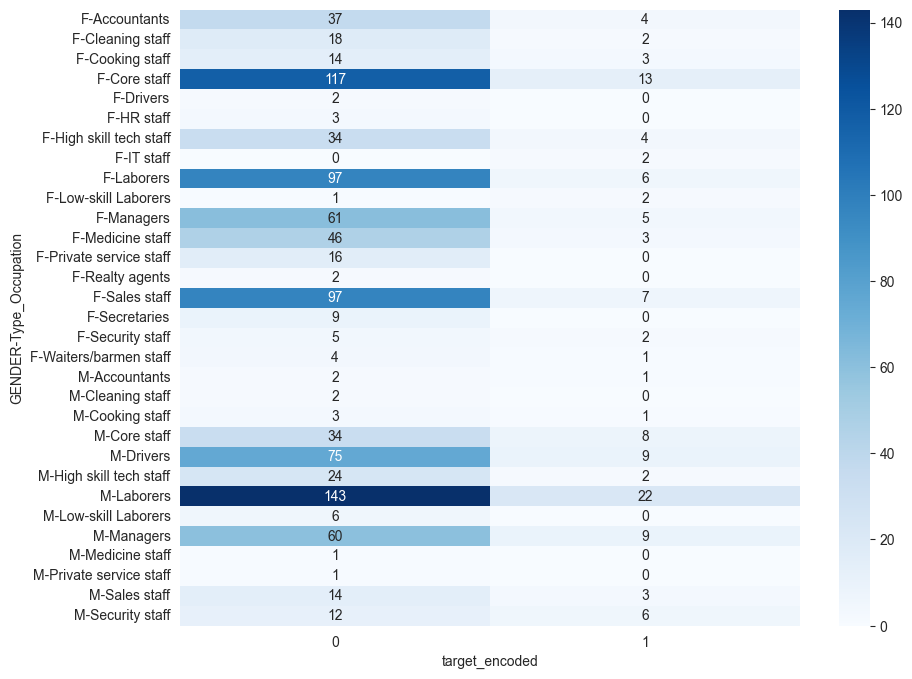

In [32]:
contract_churn = pd.crosstab([df['GENDER'], df["Type_Occupation"]], df['target_encoded'])
plt.figure(figsize = (10, 8))
sns.heatmap(contract_churn, annot = True, fmt = 'd', cmap = 'Blues')

## Cross-Variable Feature Analysis

Combines numerical and categorical features to give enhanced insights

### Swarm Plots

In [ ]:
for col in relevant_cat_cols:  
    sns.stripplot(
        x = col, 
        y ='MonthlyCharges', 
        hue = 'Churn',
        data = df, 
        size = 5,
        palette = 'viridis',
        alpha = 0.5
        )
    plt.show()

### Catplots

In [ ]:
g = sns.catplot(
    x = 'Contract', 
    y = 'MonthlyCharges', 
    hue = 'Churn', 
    col = 'PaymentMethod', 
    kind = 'box', 
    data = df,
    palette = 'Blues',
    height= 10,
    aspect = 1.2
    )


for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    


g.fig.subplots_adjust(top = 0.9)
plt.show()

### Scatter Plot

In [ ]:
sns.set_theme(style = 'white')

pairs = list(itertools.combinations(relevant_num_cols, 2))

for x_var, y_var in pairs:
    plt.figure(figsize = (12, 4))
    sns.scatterplot(
        x = x_var, 
        y = y_var, 
        hue = 'Contract', 
        style = 'Churn', 
        data = df,
        palette = 'viridis',
        s = 100
        )
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    
    plt.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

### Categorical Line Plots

In [ ]:
plt.figure(figsize = (14, 5))

sns.lineplot(
    x = 'tenure', 
    y ='MonthlyCharges', 
    hue = 'Churn', 
    data = df, 
    errorbar = None,
    palette = 'viridis',
    linewidth = 2.5
    )

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()

### Stacked Histograms

In [ ]:
palette = sns.color_palette("Set2", len(df['Contract'].unique()))  # Genera una paleta de colores

for i, contract in enumerate(df['Contract'].unique()):
    subset = df[df['Contract'] == contract]
    sns.histplot(
        subset['MonthlyCharges'], 
        label = contract, 
        kde = True, 
        alpha = 0.5,
        bins = 15,
        color = palette[i])
plt.legend()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()

### Interactions Heatmap

#### Mean and Variance Analysis

In [ ]:
# Churn vs Contract (Monthly Charges)
aggregate = ['mean', 'std']

for agg in aggregate:
    pivot_table = pd.pivot_table(
        df,
        values = 'MonthlyCharges',
        index = 'Contract',
        columns = 'Churn',
        aggfunc = agg   
    )

    plt.figure(figsize = (7, 4))

    sns.heatmap(
        pivot_table, 
        annot = True, 
        fmt = '.2f', 
        linewidths = 0.5,
        cmap = 'Blues',
        cbar = False)

    plt.title(f'{agg} of Monthly Charges by Contract and Churn')

    plt.tight_layout()
    plt.show()

In [ ]:
# Churn vs PaymentMethod (Monthly Charges)
aggregate = ['mean', 'std']

for agg in aggregate:
    pivot_table = pd.pivot_table(
        df,
        values = 'MonthlyCharges',
        index = 'PaymentMethod',
        columns = 'Churn',
        aggfunc = agg   
    )

    plt.figure(figsize = (7, 4))

    sns.heatmap(
        pivot_table, 
        annot = True, 
        fmt = '.2f', 
        linewidths = 0.5,
        cmap = 'Blues',
        cbar = False)

    plt.title(f'{agg} of Monthly Charges by Contract and Churn')

    plt.tight_layout()
    plt.show()

In [ ]:
# Churn vs Contract and PaymentMethod (Monthly Charges)
pivot_table = pd.pivot_table(
    df,
    values = 'MonthlyCharges',
    index = [df['Contract'] + '|' + df['PaymentMethod']],
    columns = 'Churn',
    aggfunc = 'mean'   
)

# ordenar filas por el promedio de MonthlyCharges
pivot_table['RowMean'] = pivot_table.mean(axis = 1)
pivot_table = pivot_table.sort_values(by = 'RowMean', ascending = False)
pivot_table = pivot_table.drop('RowMean', axis = 1)

plt.figure(figsize = (8, 6))

sns.heatmap(
    pivot_table, 
    annot = True, 
    fmt = '.2f', 
    linewidths = 0.5,
    cmap = 'Blues',
    cbar = False)


plt.title('Average Monthly Charges by PaymentMethod, Contract and Churn')

plt.tight_layout()
plt.show()

#### Min and Max Analysis

In [ ]:
# Churn vs Contract and PaymentMethod (min Monthly Charges)

combined_index = df['Contract'] + '|' + df['PaymentMethod'] 
combined_columns = df['Churn'] + '|' + df['TechSupport']
pivot_table = pd.pivot_table(
    df,
    values = 'MonthlyCharges',
    index = combined_index,
    columns = combined_columns,
    aggfunc = 'min'   
)


plt.figure(figsize = (8, 6))

sns.heatmap(
    pivot_table, 
    annot = True, 
    fmt = '.2f', 
    linewidths = 0.5,
    cmap = 'Blues',
    cbar = False)


plt.title('Minimum Monthly Charges by PaymentMethod | Contract and Churn | TechSupport')

plt.tight_layout()
plt.show()

In [ ]:
# Churn vs Contract and PaymentMethod (max Monthly Charges)

combined_index = df['Contract'] + '|' + df['PaymentMethod'] 
combined_columns = df['Churn'] + '|' + df['TechSupport']
pivot_table = pd.pivot_table(
    df,
    values = 'MonthlyCharges',
    index = combined_index,
    columns = combined_columns,
    aggfunc = 'max'   
)


plt.figure(figsize = (8, 6))

sns.heatmap(
    pivot_table, 
    annot = True, 
    fmt = '.2f', 
    linewidths = 0.5,
    cmap = 'Blues',
    cbar = False)


plt.title('Maximum Monthly Charges by PaymentMethod | Contract and Churn | TechSupport')

plt.tight_layout()
plt.show()